## About how to train your own dataset

It's optional to use lmdb format or ordinary format.

### Ordinary format

Please copy the code of '/data/BSD/py' to create your dataset file '[dataset].py' and modify '\_generate_samples()' function according to your directory structure.

### Lmdb format

Here, we take GOPRO-DS as example.

First, download and unzip the source dataset ["*gopro_ds*"](https://drive.google.com/file/d/1oICQVSIrDmaMB6R888uyGXRmWcEEQVvy/view?usp=sharing).

Then, run the following code to create lmdb file (i.e., generate 'gopro_ds_lmdb' for 'gopro_ds'):

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import lmdb
import pickle
from os.path import join

dataset_name = 'gopro' # replace with the directory name of your dataset
data_root = 'E:/deblur_data/' # replace with your own path
data_path = join(data_root, dataset_name)
lmdb_path = join(data_root, dataset_name+'_lmdb')

os.makedirs(lmdb_path, exist_ok=True)
for dataset_type in ['train', 'test']:

    # create meta-info pkl files for the dataset
    path = join(data_path, dataset_type)
    seqs = os.listdir(path)
    seqs_info = {}
    length = 0
    for i in range(len(seqs)):
        print(i)
        seq_info = {}
        seq_info['seq'] = seqs[i]
        length_temp = len(os.listdir(join(path,seqs[i],'blur_gamma')))
        seq_info['length'] = length_temp
        length += length_temp
        seqs_info[i] = seq_info
    seqs_info['length'] = length
    seqs_info['num'] = len(seqs)
    f = open(join(lmdb_path,'{}_info_{}.pkl'.format(dataset_name, dataset_type)), 'wb')
    pickle.dump(seqs_info, f)
    f.close()
    
    for dataset_label in [dataset_type, '{}_gt'.format(dataset_type)]:
        for i in range(seqs_info['num']):
            print(i)
            env = lmdb.open(join(lmdb_path, '{}_{}'.format(dataset_name, dataset_label)), map_size=10737418240)
            txn = env.begin(write=True)
            if dataset_label.endswith('gt'):
                subpath = join(path, seqs_info[i]['seq'], 'sharp')
            else:
                subpath = join(path, seqs_info[i]['seq'], 'blur_gamma')
            imgs = os.listdir(subpath)
            nums = [int(img.split('.')[0]) for img in imgs] # make sure your images are named by numbers, e.g., 0001.png.
            nums.sort()
            gap = nums[0]-0
            for img in imgs:
                img_path = join(subpath, img)
                seq_idx = i
                frame_idx = int(img.split('.')[0])-gap
                key = '%03d_%08d' % (seq_idx, frame_idx)
                data = cv2.imread(img_path)
                txn.put(key=key.encode(), value=data)
            txn.commit()
            env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10


Then, use the following code to check if the lmdb file is valid.


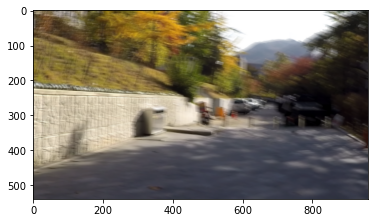

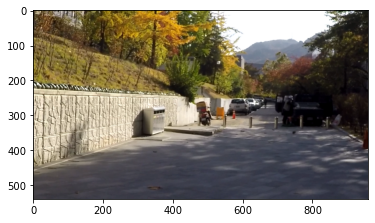

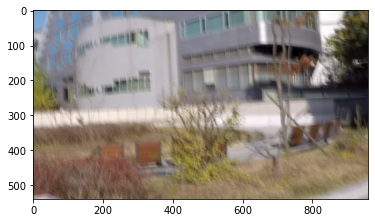

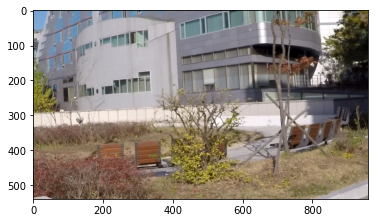

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import lmdb
import pickle
from os.path import join

H,W,C = 720,1280,3
# tarin set


env = lmdb.open(join(lmdb_path, '{}_train'.format(dataset_name)), map_size=10737418240)
env_gt = lmdb.open(join(lmdb_path, '{}_train_gt'.format(dataset_name)), map_size=10737418240)
txn = env.begin()
txn_gt = env_gt.begin()
seq = 21
frame = 39
key = '{:03d}_{:08d}'.format(seq, frame)
test = txn.get(key.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(H,W,C)
test_gt = txn_gt.get(key.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(H,W,C)
plt.imshow(test[:,:,::-1])
plt.figure()
plt.imshow(test_gt[:,:,::-1])
plt.show()
env.close()
env_gt.close()
# valid set
env = lmdb.open(join(lmdb_path, '{}_valid'.format(dataset_name)), map_size=10737418240)
env_gt = lmdb.open(join(lmdb_path, '{}_valid_gt'.format(dataset_name)), map_size=10737418240)
txn = env.begin()
txn_gt = env_gt.begin()
seq = 8
frame = 39
key = '{:03d}_{:08d}'.format(seq, frame)
test = txn.get(key.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(H,W,C)
test_gt = txn_gt.get(key.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(H,W,C)
plt.imshow(test[:,:,::-1])
plt.figure()
plt.imshow(test_gt[:,:,::-1])
plt.show()
env.close()
env_gt.close()

After generating the lmdb files, you need to creat a python file '[dataset]\_lmdb.py' under '/data' with the same name as the directory of your lmdb dataset, like 'gopro_ds_lmdb.py'.

Then, copy the code of 'gopro_ds_lmdb.py' to your dataset file '[dataset]\_lmdb.py'.

You need to modify the following arguments according to your dataset:

```
ds_name = 'gopro_ds' # [dataset]
self.W = 960 # width of image
self.H = 540 # height of image
self.C = 3 # channel of image
```

Finally, hopefully you can train your dataset by specifying the name of the dataset in cmd or default value in '/para/parameter.py'.